# Dynamics: simulation and control
This notebook focuses on the robot dynamics, for both simulating the behavior of the robot when forces are applied to it, and computing dynamic-aware control laws like computed torque.


In [1]:
import magic_donotload

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


## Set up 
We will use Pinocchio, the viewer and the QP solver quadprog. We use an ad-hoc model of a robot hand with simple geometry to make the contact simulation problem simple. 


In [2]:
import math
import time
import pinocchio as pin
import numpy as np
from numpy.random import rand
from numpy.linalg import inv,pinv,norm,eig,svd
import matplotlib.pylab as plt; plt.ion()
import quadprog
from tp4.robot_hand import RobotHand
from utils.meshcat_viewer_wrapper import MeshcatVisualizer

## QuadProg solver
QuadProg is a simple QP solver that is very convenient to import in Python and very simple to use. 

A simple example using QuadProg is as follow. First randomly define a QP problem is

$$\min_x \frac{1}{2} x^T A x - b^T x$$
Under the constraints:
$$C x \ge d$$

In [3]:
A = np.random.rand(5,5)*2-1
A = A @ A.T ### Make it positive symmetric
b = np.random.rand(5)

C = np.random.rand(10, 5)
d = np.random.rand(10)


The quadratic program can be solved by calling:

In [4]:
[x,cost,_,niter,lag,iact] = quadprog.solve_qp(A,b,C.T,d)  # Notice that C.T is passed instead of C

where x is the solution, cost is the value of the cost function at x, niter is the number of iterations needed to obtain the optimum, lag is the dual optimum (lagrange multipliers) and iact are the active constraints (numbered from 1 to N, i.e. lag[iact-1] is not null). See the doc for more details.

In [5]:
# help(quadprog.solve_qp)

## A robot hand for our test

We are going to use a 4-finger hand, whose model is defined in Python (no urdf model) using capsule volumes.
The hand is defined in the python code robot_hand.py. You can load and 
display it like this (don't forget to turn gepetto-viewer on with starting gepetto-gui).

In [6]:
robot = RobotHand()
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [7]:
viz.viewer.jupyter_cell()

### Interactive sliders (for geeks)

For this one, you need to additionally install [ipywidgets](https://github.com/jupyter-widgets/ipywidgets/blob/8.0.0b1/docs/source/examples/Widget%20Basics.ipynb). Execute the following then restart your jupyter process:

```
jupyter nbextension enable --py widgetsnbextension
```


Never mind, we don't really need it. You can also play with the hand by changing its configuration manually. 

Take care that the hand is small: zoom in to see it in the window.

In [8]:
try:
    q0 = robot.q0.copy()
    from ipywidgets import interact
    @interact(thumb=(-.5, 1.5, 0.01))
    def move_thumb(thumb=0.7):
        q0[11:] = thumb
        viz.display(q0)
    @interact(others=(0., 2., 0.1))
    def move_fingers(others=0.3):
        q0[1:11] = others
        viz.display(q0)
except:
    print('iPyWidget should be installed, see above. ')

interactive(children=(FloatSlider(value=0.7, description='thumb', max=1.5, min=-0.5, step=0.01), Output()), _d…

interactive(children=(FloatSlider(value=0.3, description='others', max=2.0), Output()), _dom_classes=('widget-…

Remember that the model rendered in the viewer is just a display, not a simulation (yet).  You can pretty much achieve any movements you want in this display, because we are not enforcing (yet) any physical law. For example, if you want to move the fingers following any trajectories you like, you can do:

In [9]:
q = robot.q0.copy()

for i in range(500): # Put 1000 or 5000 if you want a longer move.
    for iq in range(3,robot.model.nq):
        q[iq] = -1+np.cos(i*1e-2*(1+iq/5))
    viz.display(q)
    time.sleep(2e-3)


## Forward unconstrained dynamics
### Computing the acceleration

In a first time, let's play with the dynamics without constraints (hence without quadprog).

Choosing an arbitrary joint torque $\tau_q$, pinocchio can compute the robot acceleration and integrate it.

The dynamic equation of the robot is $M a_q + b = \tau_q$, with $M$ the mass, $a_q$ the joint acceleration and $b$ the drift.
The mass matrix can be computed using *CRB* algorithm (function of q). The drift is computed using *NLE* (nonlinear effects) algorithm (function of $q$, $v_q$). Which contains normal gravity and coriolis effect.

In [10]:
q = robot.q0.copy()
vq = np.zeros(robot.model.nv)

In [11]:
M = pin.crba(robot.model, robot.data, q)
b = pin.nle(robot.model, robot.data, q, vq)

These terms correspond to the inverse dynamics. They can be numerically inverted to compute the direct dynamics.

Using $M$ and $b$ computed by the above algorithms, and knowing a given set of joint torques $\tau_q$, how would you compute the accelration $a_q$ `aq` induce by the torques ?

In [12]:
tauq = np.random.rand(robot.model.nv)
aq = np.random.rand(robot.model.nv)  # Replace me

In [13]:
# %load tp4/generated/solution_pd_dyninv
tauq = np.random.rand(robot.model.nv)
aq = inv(M) @ (tauq - b)

The inverse-dynamics algorithm indeed compute the needed torques to achieve a given acceleration. We can use the *RNEA* (for forward dynamics) function to double-check our result:

In [14]:
print(norm(pin.rnea(robot.model,robot.data,q,vq,aq)-tauq))

6.359601310784501e-16


### Integrating the acceleration

Once aq as been computed, it is straight forward to integrate it to velocity using $v_q = v_q + a_q \Delta t$. 
Integration to joint position is more complex in general, as we saw for the mobile robot. Here, $n_q = n_v$ and everything is Euclinea, so a simple += integration would work, but since it is implemented in pinocchio, let's keep the good habits and use general integration.

In [15]:
dt = 2e-3
N_steps = 5000

In [16]:
vq += np.random.rand(robot.model.nv)  # Replace me
q = np.random.rand(robot.model.nq)  # Replace me

In [17]:
# %load tp4/generated/solution_pd_integrate
vq += aq * dt
q = pin.integrate(robot.model, q, vq * dt)

Now, you should be able to implement a first simulation (not a rendering any more) of the robot behavior when no torque is applied (tauq = 0).



Init simulation

In [18]:
q = robot.q0.copy()
viz.display(q)
vq = np.zeros(robot.model.nv)

Fill the template below to get a free-falling dynamics.

In [19]:
for it in range(N_steps):
    t = it*dt

    # Retrieve the dynamics quantity at time t
    M = np.eye(robot.model.nv)        # REPLACE ME
    b = np.zeros(robot.model.nv)      # REPLACE ME

    # Compute the force that apply
    tauq = np.zeros(robot.model.nv)

    # Use generalized PFD to calculate aq
    aq = np.zeros(robot.model.nv)     # REPLACE ME

    # Double integration to update vs and q
    vq = np.zeros(robot.model.nv)    # REPLACE ME
    q  = np.zeros(robot.model.nq)   # REPLACE ME

    # Visualization
    if it%20==0: 
        viz.display(q)
        time.sleep(20*dt)


Here is the solution

In [21]:
# %load tp4/generated/solution_pd_freefall
for it in range(N_steps):
    t = it*dt

    # Dynamics at time t
    M = pin.crba(robot.model, robot.data, q)
    b = pin.nle(robot.model, robot.data, q, vq)

    # Force that apply
    tauq = np.zeros(robot.model.nv)

    # PFD
    aq = inv(M) @ (tauq - b)

    # Double integration
    vq += aq * dt
    q = pin.integrate(robot.model, q, vq * dt)

    # Visualization
    if it%20==0: 
        viz.display(q)
        time.sleep(20*dt)


Now modify the simulator code above to encompass joint friction, i.e. the torque is opposite to the velocity with a friction coefficient $K_f$ (take $K_f=0.1$ as a start).

In [21]:
q = robot.q0.copy()
viz.display(q)
vq = np.zeros(robot.model.nv)
Kf = 0.1

In [22]:
# Use the same loop templace as above

In [23]:
# %load tp4/generated/solution_pd_frictionfall
for it in range(N_steps):
    t = it*dt

    # Dynamics at time t
    M = pin.crba(robot.model, robot.data, q)
    b = pin.nle(robot.model, robot.data, q, vq)

    # Force that apply
    tauq = - 0.1 * vq

    # PFD
    aq = inv(M) @ (tauq - b)

    # Double integration
    vq += aq * dt
    q = pin.integrate(robot.model, q, vq * dt)

    # Visualization
    if it%20==0: 
        viz.display(q)
        time.sleep(20*dt)


## Proportional-derivative and computed torque

Now choose a reference joint position.
The joint torques can then be computed to track the desired position, with $\tau_q = -K_p (q-q^{des}) - K_v (\dot{q} - \dot{q}^{des})$. Both gains $K_p$ and $K_v$ should be properly chosen. Optimal tracking is obtained with $K_v = 2 \sqrt{K_p}$. 
In general, a desired velocity is also tracked to avoid tracking errors.



First choose the PD gains and simulation parameter:

In [24]:
q = np.zeros(robot.model.nq)
viz.display(q)
vq = np.zeros(robot.model.nv)
# Hyperparameters for the control and the simu
Kf = 0.1
Kp = 50.               # proportional gain (P of PD)
Kv = 2 * np.sqrt(Kp)   # derivative gain (D of PD)
dt = 2e-3             # simulation timestep
N_steps = 5000

Then choose the reference trajectory.

In [25]:
from tp4.traj_ref import TrajRef
qdes = TrajRef(robot.q0,omega = np.array([0.,.1,1,1.5,2.5,-1,-1.5,-2.5,.1,.2,.3,.4,.5,.6]),amplitude=1.5)

Finally, implement the control loop using the following template.

In [26]:
for it in range(N_steps):
    t = it*dt

    # Retrieve the dynamics quantity at time t
    M = np.eye(robot.model.nv)        # REPLACE ME
    b = np.zeros(robot.model.nv)      # REPLACE ME

    # Compute the force that apply
    tauq = np.zeros(robot.model.nv)

    # Use generalized PFD to calculate aq
    aq = np.zeros(robot.model.nv)     # REPLACE ME

    # Double integration to update vs and q
    vq = np.zeros(robot.model.nv)    # REPLACE ME
    q  = np.zeros(robot.model.nq)   # REPLACE ME

    # Visualization
    if it%20==0: 
        viz.display(q)
        time.sleep(20*dt)


Here is the solution, should you need it.

In [27]:
hq    = []   ### For storing the logs of measured trajectory q
hqdes = []   ### For storing the logs of desired trajectory qdes
for it in range(N_steps):
    t = it*dt

    # Compute the model.
    M = pin.crba(robot.model, robot.data, q)
    b = pin.nle(robot.model, robot.data, q, vq)

    # Compute the PD control.
    tauq = -Kp*(q-qdes(t)) - Kv*(vq-qdes.velocity(t))
    tauq_frottement = -Kf * vq
    
    # Simulated the resulting acceleration (forward dynamics
    aq = inv(M) @ (tauq_frottement + tauq - b)

    # Integrate the acceleration.
    vq += aq * dt
    q = pin.integrate(robot.model, q, vq * dt)

    # Display every TDISP iterations.
    TDISP = 50e-3    # Display every 50ms
    if not it % int(TDISP/dt):  # Only display once in a while ...
        viz.display(q)
        time.sleep(TDISP)

    # Log the history.
    hq.append(q.copy())
    hqdes.append(qdes.copy())


Here, there is a strong coupling between joints, due to the mass matrix that is not compensated in the simple PD law. In theory, the computed torques is to compute the joint torque by inverse dynamics from a reference joint acceleration. This boils down to canceling the simulation equation by choosing the proper terms in the control law. It is now very interesting to implement in case of perfect dynamics knowledge. It might be more interesting to study in case the simulation is done with the perfect M, while the control is computed with approximate M (for example, using only the diagonal terms of the mass matrix). Let's rather simulate contact.


It is intersting to plot the results. In the solution of the previous example, the effective and desired position q and qdes have been stored in a log list. We can display them with matplotlib.

In [28]:
def plot_joint_profiles(i, hq, hqdes):
    plt.subplot(111)
    plt.plot([q[i] for q in hq])
    plt.plot([q[i] for q in hqdes])
    plt.ylabel(f'Joint {i}')


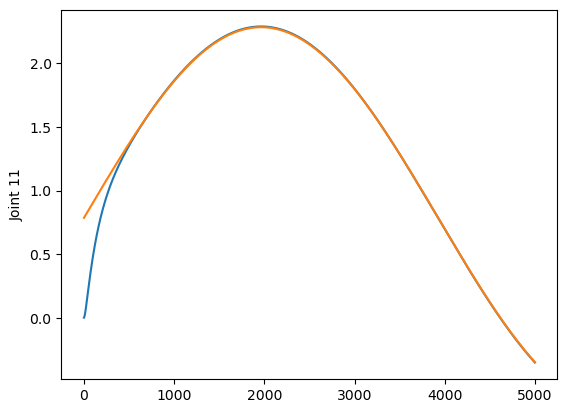

In [29]:
plot_joint_profiles(11, hq, hqdes)

## Collision checking

Pinocchio is built on top of HPP FCL (a fork of the Free-Collision-Lib) to compute collision and distances. For this notebook, a wrapper as been set up to make the computation easier.


In [30]:
from tp4.collision_wrapper import CollisionWrapper
colwrap = CollisionWrapper(robot)
colwrap.computeCollisions(q)
collisions = colwrap.getCollisionList()

`getCollisionList` returns a list of all the active collisions. The list containts triplets `i,c,r`, with `i` the index of the collision pair, `c` the collition pair and `r` a structure containg the collision details, in particular the collision position in world frame and the collision normal. 

From this list, it is possible to compute various quantities, in particular the contact Jacobian (corresponding to the normal direct of each contact), which convert configuration velocities into veolocity of the contact interfaces. The contact distances noted $e$, and the self-acceleration of the contact point (similar to Coriolis acceleration, i.e. due to the velocity of the joints, also denoted by $\dot{J}\dot{q}$.

In [31]:
dist=colwrap.getCollisionDistances(collisions)
J = colwrap.getCollisionJacobian(collisions)

The contact accelereation is indeed $$v_c = \frac{d e}{dt} = J \dot{q}$$ $$a_c = \frac{d v_c}{dt} = \frac{d J \dot{q}}{dt} = J \ddot{q} + \dot{J}\dot{q}$$where $\dot{J}\dot{q}$ is a Coriolis term. This can be computed if calling `colwrap.computeCollision(q,vq)` (add the vq argument). Now, `colwrap.getCollisionJdotQdot` will return the self-acceleration.

In [32]:
colwrap.computeCollisions(q, vq)
collisions = colwrap.getCollisionList()
dist=colwrap.getCollisionDistances(collisions)
J = colwrap.getCollisionJacobian(collisions)
JdotQdot = colwrap.getCollisionJdotQdot()

Better try this with a configuration of the hand where there are some collisions.

## Contact simulator

### 1. Enforce positive acceleration 

The joint acceleration is constrained by the contact constraint: it can only go appart. It can be written as a minimization problem using Gauss principle:
$$min \quad \frac{1}{2}  (\ddot{q} - \ddot{q}_0 )^T M (\ddot{q} - \ddot{q}_0 )$$
$$s.t. \quad \frac{d J \dot{q}}{dt} >= 0 $$
where $ \ddot{q}_0 = M^{-1} (\tau-b)$ is the free acceleration, i.e. the acceleration obtained in Question 2 where no constraint is active.

This modelis physical, but because the simulation is time stepped, we need to adapt the physic to get a simulation closer to the reality.

### 2. Impact
When creating the contact with a non-zero velocity, enforcing a null acceleration is not sufficient as the two bodies will penetrate during the time step. When a new contact is created, the velocity of the contact normals should be nullified to render physic. You can do that by projecting the current velocity in the null space of the normal jacobian of the new contacts. Ideally, this projection should be done while respecting the Gauss principle, but that is a little bit too advanced for the purpose of this notebook.

### 3. Penetration correction
Enforcing 0 velocity at impact and 0 acceleration later should be enough in theory. Yet some numerical drift might push the bodies inside each other. We can then enforce the contact acceleration to be at least a PD pushing the two volums out of each other to nullify the numerical drift effect. We enforce $a_c >= PD(e, v_v)$. The constraint become:
$$ J \ddot{q} + \dot{J}\dot{q} \ge -K_p^c e -K_v^c J \dot{q}$$


You are now all set up for implementing the contact simulator.
The complete loop should be as follows:
- torque is computed from a PD tracking a time-varying joint position (question 3).
- After computing torque, all collision pairs must be checked to find those with distances collision penetrating more than $10 ^{-4}$
- Corresponding Jacobians must be computed and stacked. If a new collision has appeared, the joint velocity must be projected to nullify it.
- If not collision is active, the joint acceleration is computed from inverting the mass matrix (question 2).
- Otherwise, it is computed using QP (question 4).
- The resulting acceleration is integrated twice (question 1) before displaying the robot starting a new simulation iteration.

You can start from the same template as the freecontact solver.

In [39]:
q = np.zeros(robot.model.nq)
viz.display(q)
vq = np.zeros(robot.model.nv)

# Hyperparameters for the control and the simu
Kf = 0.1
Kp = 50.               # proportional gain (P of PD)
Kv = 2 * np.sqrt(Kp)   # derivative gain (D of PD)

dt = 1e-3             # simulation timestep
N_steps = 10000

Kp_c = 100.
Kv_c = 2 * np.sqrt(Kp_c)

qdes = TrajRef(robot.q0,omega = np.array([0.,.1,1,1.5,2.5,-1,-1.5,-2.5,.1,.2,.3,.4,.5,.6]),amplitude=1.5)

Start from the previous templates and add the contact simulation.

In [40]:
# %load tp4/generated/solution_contact_simulator
hq_c    = []   ### For storing the logs of measured trajectory q
hqdes_c = []   ### For storing the logs of desired trajectory qdes

already_contact = set()  # Track contact

for it in range(N_steps):
    t = it*dt

    # Compute the model.
    M = pin.crba(robot.model, robot.data, q)
    b = pin.nle(robot.model, robot.data, q, vq)

    # Compute the PD control.
    tauq = - Kp * (q - qdes(t)) - Kv * (vq - qdes.velocity(t))
    tauq_frottement = - Kf * vq
    
    # Simulated the resulting acceleration (forward dynamics
    aq0 = inv(M) @ (tauq_frottement + tauq - b)

    # Check collision
    colwrap.computeCollisions(q, vq)
    raw_collisions = colwrap.getCollisionList()
    raw_dist = colwrap.getCollisionDistances(raw_collisions)

    # Keep only real colision
    collisions = [c for c, d in zip(raw_collisions, raw_dist) if d <= -1e-4]

    if not collisions:
        aq = aq0
        already_contact = set()
    else:
        dist = colwrap.getCollisionDistances(collisions)
        J = colwrap.getCollisionJacobian(collisions)
        JdotQdot = colwrap.getCollisionJdotQdot(collisions)

        # Update contact tracking and nullify velocity of new contact
        col_id = [e[0] for e in collisions]
        new_col_idx = [i for i, e in enumerate(col_id) if e not in already_contact]
        already_contact = set(col_id)
        if new_col_idx:
            J_proj = np.stack([J[i] for i in new_col_idx], axis=0)
            vq -= (pinv(J_proj) @ J_proj) @ vq

        # Find real acceleration using Gauss principle
        A = M
        b = M @ aq0
        C = J
        d = - JdotQdot - Kp_c * dist - Kv_c * J @ vq
        [aq,cost,_,niter,lag,iact] = quadprog.solve_qp(A,b,C.T,d)  # Notice that C.T is passed instead of C

    # Integrate the acceleration.
    vq += aq * dt
    q = pin.integrate(robot.model, q, vq * dt)

    # Display every TDISP iterations.
    TDISP = 50e-3    # Display every 50ms
    if not it % int(TDISP/dt):  # Only display once in a while ...
        viz.display(q)
        time.sleep(TDISP)

    # Log the history.
    hq_c.append(q.copy())
    hqdes_c.append(qdes.copy())


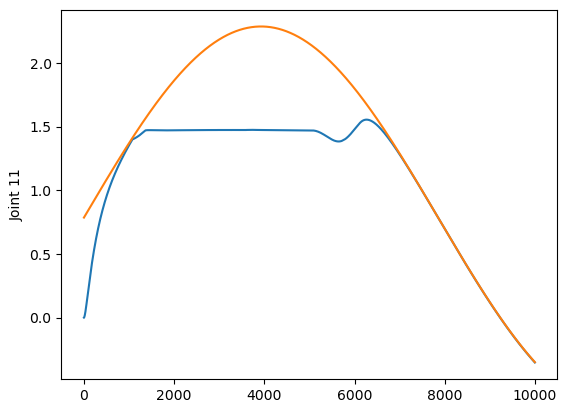

In [35]:
plot_joint_profiles(11, hq_c, hqdes_c)

What are all the problematic that can be explored ?
- integrators
- QP solvers
- Other physic principles (e.g. Coulomb)
- Other controller than PD
- Numerical conditioning, footprint, convergence of algorithms